# Comparison of Full Grid Stereo with Window-based and Scanline Approaches

## Team Members & Contributions

Soyeon Shin: 

- Middlebury data ingestion
- image dictionary creation
- displaying algorithm outputs
- algorithm result analyses for every approach
- concluding performance comparison with ground truth
- window/scanline approach from previous assignment

Umer Amjad: 

- abstract
- introduction
- algorithm descriptions for every approach
- full grid / graph cuts implementation
- concluding analysis
- window/scanline approach from previous assignment

## Code Libraries


As with previous assignments, we used Python3 with Numpy, Matplotlib, and PIL, all of which come installed with Anaconda by default. 

We used OpenCV to resize the input images to make them smaller. This can be installed with:

`conda install -c conda-forge opencv`

We used PyMaxFlow to implement the full grid stereo via graph cuts. This can be installed with:

`pip install PyMaxFlow`

To read the ground-truth disparities in the Middlebury dataset (provided as PFM files), we used a function called `load_pfm` which can be found here: https://gist.github.com/chpatrick/8935738. It is included in the code below, so no download or installation is needed.

## Abstract

Stereo images are a pair of images lying on the same image plane, such that one of the images is slightly horizontally offset from the other. Given such a pair, we can measure depth by noticing how much each pixel needs to move from the left image to the right image. Objects in the background will move less, while objects in the foreground will move more - thus, this "movement'' of pixels is inversely proportional to their depth. We call this movement "disparity", and this project will analyze several methods of calculating disparities given a pair of stero images. To test our results, we use stero image pairs from the Middlebury Datasets: in particular, the Tsukuba image, and various images from their 2014 dataset. These can be found here: https://vision.middlebury.edu/stereo/data/. These datasets include the "ground truth'' disparities, which we will compare against to judge the performance of our algorithms. 

To calculate disparity for some object, we can first calculate the overall colour distance between that object in the left image and that object in the right image shifted by some disparity. Then, over a range of disparities, the disparity with the lowest colour distance is likely going to be the disparity of that object - it will be when those objects in the left image and the shifted right image have the most overlap. This is the basic idea that all of our algorithms use. However, in order to implement this idea, it's not enough to calculate these color distances for every pixel, because at a pixel does not have the information about which object it is part of or its surroundings.

We will use three different types of algorithms to deal with this issue. For the first, instead of calculating distance between pixels, we choose a window around the pixels over which to calculate distance. This is the "window-based" approach.  Our second algorithm type calculates disparities along every scanline of both images, with weights added so that disparities within a scanlines are regularized. This uses the Viterbi algorithm. We also combine the window-based approach with the scanline approach. We can think of this algorithm as enforcing spatial-consistency, but only for every scanline indidivually. Thus, the third type of algorithm we use enforces spatial-consistency in both the horizontal and vertical directions, by finding a graph cut of a three dimensional graph which has two dimensions of edge weights for spatial consistency (the horizontal and vertical directions of the image), and one dimension of edge weights for every disparity within a range of disparities. We also implement a smarter version of this algorithm where the spatial consistency weights depend on the intensity contrast between neighbouring pixels. Overall, the graph cuts approach consistently gives the best results compared to the others. 

## 0 Introduction
First, we will load up the images, and display them along with ground truth disparities.

Then the following sections will discuss:
1. Window approach
2. Scanline approach
3. Full Grid approach 

respectively. Within each section, the algorithms use different parameters which will lead to different results. We compare the results using the different parameters within each section. Then in the final section, we will compare the different algorithms amongst themselves.

### 0.1 Load Images
First we load up the images from the Middlebury Datasets, provided in the `images` folder. We scale the images down because otherwise they are too large. Additionally, to calculate our range of disparities, we calculate the minimum and maximum disparities using the ground-truth provided. We store the results in a dictionary for later use in our algorithms

In [1]:
%matplotlib inline
import re
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
INFTY = np.inf


# read image with pillow and convert to np array
def im_read(image_path):
    return np.array(Image.open(image_path))

# source: https://gist.github.com/chpatrick/8935738
# this function is used to load PFM files containing ground truth for Middlebury dataset
def load_pfm(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode('ascii') == 'PF':
        color = True    
    elif header.decode('ascii') == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.search(r'(\d+)\s(\d+)', file.readline().decode('ascii'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)
    return np.reshape(data, shape), scale

# first add Tsukuba images

image_dir = "images/"
tsukuba_dir = image_dir + "tsukuba/"

# dict of image to image info
images = {}

# images/tsukuba subdirectory contains (a subset of) "Tsukuba" stereo images that are probably 
# the oldest stereo data with dense ground-truth produced at the University of Tsukuba in 2001. 
# The full Tsukuba dataset and many other stereo images with ground-truth disparity maps can be
# downloaded from well-known Middlebury repository  http://vision.middlebury.edu/stereo/
im_left = im_read(tsukuba_dir + "scene1.row3.col3.ppm")
im_right = im_read(tsukuba_dir + "scene1.row3.col4.ppm")
im_gt = im_read(tsukuba_dir + "truedisp.row3.col3.pgm")
# disparities scaled by 16
im_gt = im_gt / 16

d_min = int(np.amin(im_gt[np.nonzero(im_gt)]))
d_max = int(np.amax(im_gt))

images['tsukuba'] = {
    'left': im_left,
    'right': im_right,
    'gt': im_gt,
    'd_min': d_min,
    'd_max': d_max
}

middlebury_dir = image_dir + "Middlebury/"

for d in os.listdir(middlebury_dir):
    im_left = im_read(middlebury_dir + d + "/im0.png")
    im_right = im_read(middlebury_dir + d + "/im1.png")
    
    scale_down = 8
    # scale the images 
    scaled_dim = (int(im_left.shape[1] / scale_down), int(im_left.shape[0] / scale_down))
    im_left = cv2.resize(im_left, scaled_dim, interpolation = cv2.INTER_AREA)
    im_right = cv2.resize(im_right, scaled_dim, interpolation = cv2.INTER_AREA)

    im_gt, _ = load_pfm(middlebury_dir  + d + "/disp0.pfm")
    im_gt = np.flip(im_gt, axis = 0) # load pfm gives it upside down
    im_gt = cv2.resize(im_gt, scaled_dim, interpolation = cv2.INTER_AREA)
    im_gt = im_gt/scale_down
    
    d_min =  int(np.amin(im_gt[im_gt != np.inf]))
    d_max = int(np.amax(im_gt[im_gt != np.inf]))

    im_gt[im_gt==np.inf] = 0
    
    # store in dictionary for later use
    images[d] = {
        'left': im_left,
        'right': im_right,
        'gt': im_gt,
        'd_min': d_min,
        'd_max': d_max
    }
    


### 0.2 Display Images
Below we display the left and right images, along with ground truth disparities. We also define functions to help display which we use later too. 

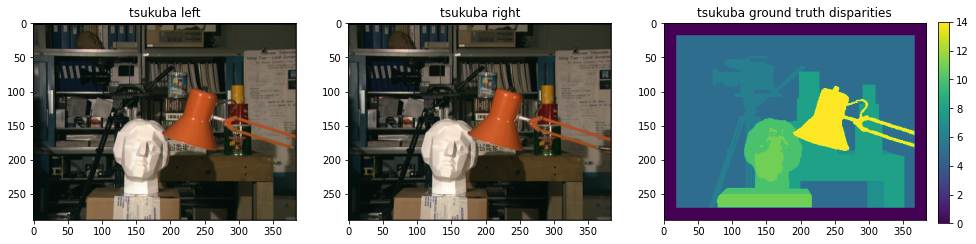

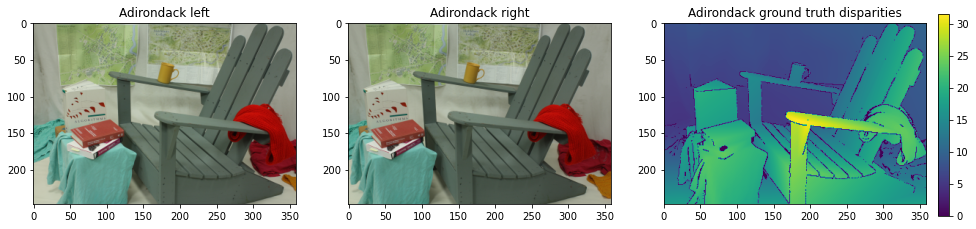

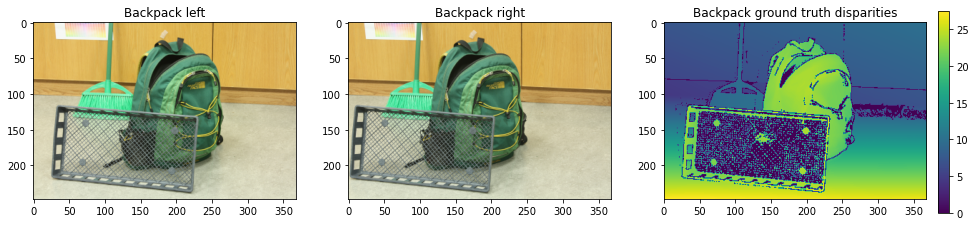

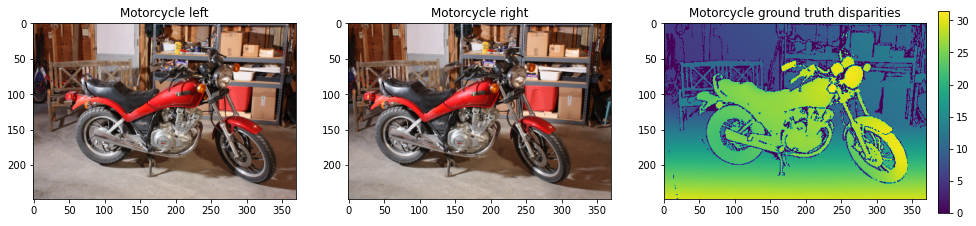

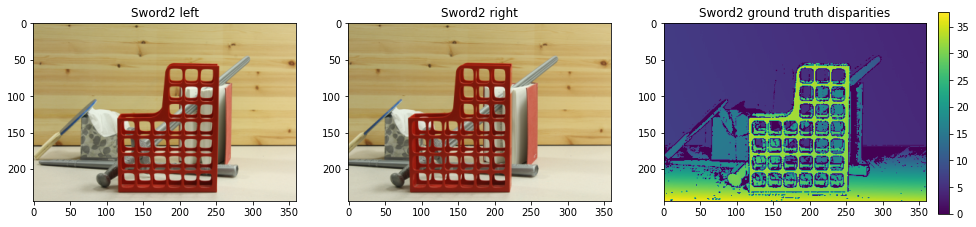

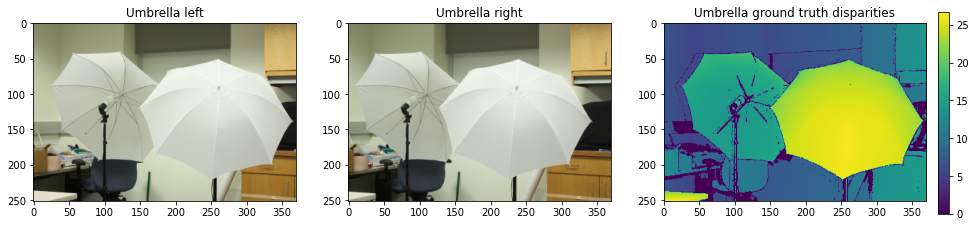

In [2]:
# plots a row of images
# if using vmin and vmax, they must share that value 
def display_image_plots(plots, titles, fig_size = (16, 7), vmin = None, vmax = None, colorbar_info = None):
    fig = plt.figure(figsize = fig_size)
    plot_location = 100 + len(plots)*10
    for i, plot in enumerate(plots):
        plt.subplot(plot_location + i + 1)
        plt.title(titles[i])
        if vmin and vmax:
            plt.imshow(plot, vmin = vmin, vmax = vmax)
        else:
            plt.imshow(plot)
    if colorbar_info:
        plt.colorbar(cax = plt.axes(colorbar_info))
    plt.show()
        

# display left, right, and gt

for name, info in images.items():
    plots = [info['left'], info['right'], info['gt']]
    titles = [name + " left", name + " right", name + " ground truth disparities"]
    display_image_plots(plots, titles, colorbar_info = [0.91, 0.3, 0.01, 0.4])

    

## 1 Window Based Stereo

This algorithm will compare color distances between windows around pixels in the left image and the right image shifted by some disparity. The code here is copied over from our implementation of window-based stereo disparities from Assignment 3.

The windows around each pixel look like the following (also taken from A3):  
<img src="images\windows.png">

The `SD_array` function below calculates the squared distance between pixels in the left image and the right image shifted by some disparities, for every disparity from `d_minimum` to `d_maximum` inclusive. The `integral_image` function creates an integral image which allows faster calculation of the sum of distances within corresponding windows. The function `windSum` calculates this. After finding these sums for each disparity level and each pixel, the function `SSDtoDmap` picks the disparity level with the lowest sum for every pixel, and returns a 2D array of the disparity for each pixel, which we call a disparity map or `dispmap`. The function `windows_dismap` calls the functions mentioned as necessary and returns the disparity map. 

### 1.1 Implementation

In [3]:
def SD_array(imageL, imageR, d_minimum, d_maximum):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))
    imlf = imageL
    imrf = imageR
    
    for i, d in enumerate(range(d_minimum, d_maximum+1)):
        shiftr = np.roll(imrf, d, axis = 1)
        SD[i] = np.sum(np.square(imlf - shiftr), axis = 2)

    return SD

def integral_image(img):
    integral = np.zeros((np.shape(img)[0],np.shape(img)[1]))
    for r, row in enumerate(img):
        row_sums = np.cumsum(row)
        integral[r] = row_sums
        if r > 0:
            integral[r] += integral[r-1]
    return integral

def windSum(img, window_width):
    integral = integral_image(img)
    forward_half = window_width // 2
    backward_half = window_width - forward_half

    br = np.roll(integral, (-forward_half, -forward_half), axis = (0, 1)) # bottom right
    bl = np.roll(integral, (-forward_half, backward_half), axis = (0, 1)) # bottom left
    tr = np.roll(integral, (backward_half, -forward_half), axis = (0, 1)) # top right
    tl = np.roll(integral, (backward_half, backward_half), axis = (0, 1)) # top left
    
    result =  br - bl - tr + tl
    if window_width > 1:
        if backward_half > 0:
            result[:backward_half, :] = INFTY
            result[:, :backward_half] = INFTY
        if forward_half > 0:
            result[-forward_half:, :] = INFTY
            result[:, -forward_half:] = INFTY
    return result

def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    argmin = np.argmin(SSD_array, axis=0)
    minval = np.take_along_axis(SSD_array, np.expand_dims(argmin, axis = 0), axis = 0)[0, : , :]
    dmap = d_minimum + argmin
    return np.where(np.isinf(minval), 0, dmap)

def window_dispmap(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    SSD = np.zeros(np.shape(SD))
    for d in range(1 + d_maximum - d_minimum):
        SSD[d] = windSum(SD[d], window_width)
    dMap = SSDtoDmap(SSD, d_minimum, d_maximum)
    return dMap 

### 1.2 Results

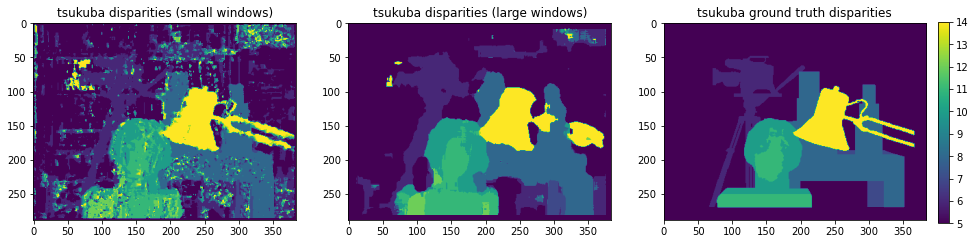

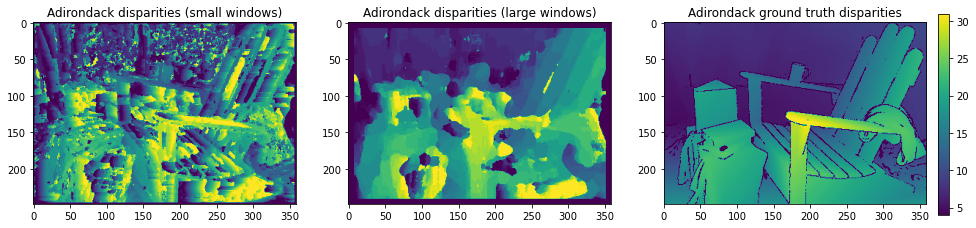

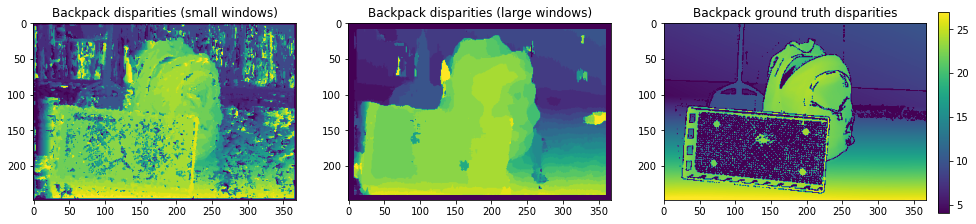

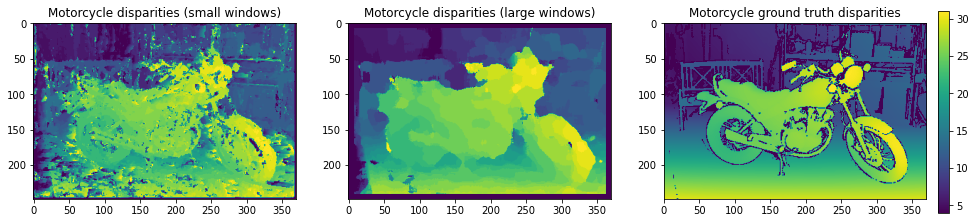

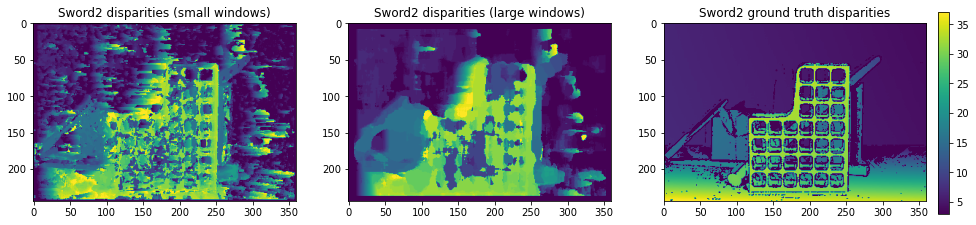

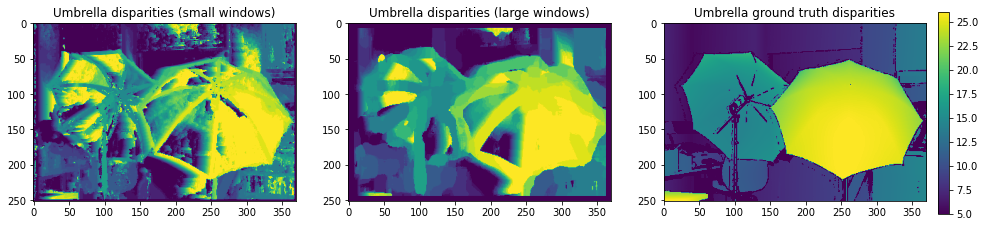

In [4]:
for name, info in images.items():
    images[name]['window_small'] = window_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 4)
    images[name]['window_large'] = window_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15)
    plots = [images[name]['window_small'], images[name]['window_large'], info['gt']]
    titles = [name + " disparities (small windows)", name + " disparities (large windows)", name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])


### 1.3 Analysis

When using a smaller window for the window-based approach, the resulting disparities contained more noise. However, having a larger window resulted in less noise but blotched out details.


## 2 Scan-line Stereo

In this section, we use the Viterbi algorithm to minimize the loss function over a scanline of pixels $S$:

$$E(d) = \sum_{p \in S} D_p(d_p) + \sum_{p \in S} V(d_p, d_{p+1}) $$

The terms in the first sum are photo-consistency terms, whereas the terms in the second sum are the spatial coherence terms (or regulization weights). For the regulization weights, we will use $V(d_p, d_{p+1}) = w \cdot |d_p - d_{p+1}|$ for some choice of $w$, which is the regularization factor. Higher values of $w$ will make disparity jumps less likely.

We can think of these costs as giving as weights for a two dimensional directed graph of nodes (given by "squaring'' the scanline), where in one dimension the edge weights are given by the photoconsistency terms, and in the other dimension the edge weights are given by the spatial coherence terms. Then, we can find the shortest path between opposite corners of our graph to get the choice of disparities which minimizes our loss function. We use the Viterbi algorithm to find this path and the disparities. 

### 2.1 Viterbi (basic)

For the basic implementation of this algorithm, we will use the sum of squared differences of intensities our image as in before for our photo consistency terms. That is, 

$$D_p(d) = |I_p - I'_{p \oplus d}|^2 = SD\_array[d][p]$$

Thus, we use the `SD_array` function implemented for the first algorithm. 


#### 2.1.1 Implementation

In [5]:

# returns E, Prev
def viterbi_scanline(r, scanline, disps, photo_const, reg_weight):
    E = np.zeros((len(scanline), len(disps))) # row i is E_bar_i()
    Prev = np.zeros((len(scanline), len(disps)), dtype = int) # keep track of minimum chosen 
    for c, cell in enumerate(scanline):
        if c == 0:
            continue
        prev_E = np.tile(E[c-1], (len(disps), 1))
        photo_consts = np.tile(photo_const[:, r , c-1], (len(disps), 1))
        loss = reg_weight + prev_E + photo_consts
        Prev[c] = np.argmin(loss, axis = 1)
        E[c] = loss[np.arange(np.shape(loss)[0]), Prev[c]]
    return E, Prev


def viterbi_image(img, disps, photo_const, reg_weight):
    dmap = np.zeros((np.shape(img)[0], np.shape(img)[1]))
    for r, scanline in enumerate(img):
    
        E, Prev = viterbi_scanline(r, scanline, disps, photo_const, reg_weight)
        # look at index of min of last row of E
        index =  np.argmin(E[-1])
        # get back all previous disparaties based on that minimum
        for c in reversed(range(len(scanline))):
            dmap[r][c] = disps[index]
            index = Prev[c][index]
    return dmap

# w is the regulization factor
def basic_viterbi_dispmap(im_left, im_right, d_min, d_max, w):
    # SD gives the array of Dp(d) for pixel p and disparity d
    # So to get edge costs E(p, p+1) = Dp + V(p, p+1)
    # we can create an array of edge costs:
    SD = SD_array(im_left, im_right, d_min, d_max)
    
    disps = np.array(range(d_min, d_max + 1))
    # matrix of regularization weights for disparities:
    disp_curr = np.transpose(np.tile(disps, (len(disps), 1)))
    disp_prev = np.tile(disps, (len(disps), 1))
    reg_weight = w * np.absolute(disp_curr - disp_prev)
    
    return viterbi_image(im_right, disps, SD, reg_weight)

#### 2.1.2 Results

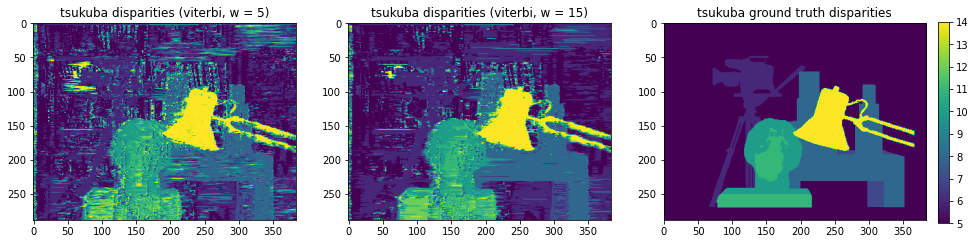

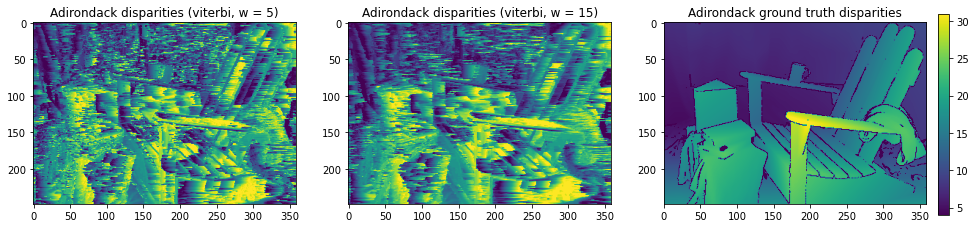

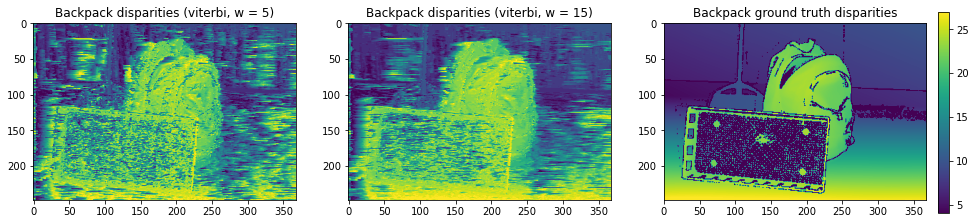

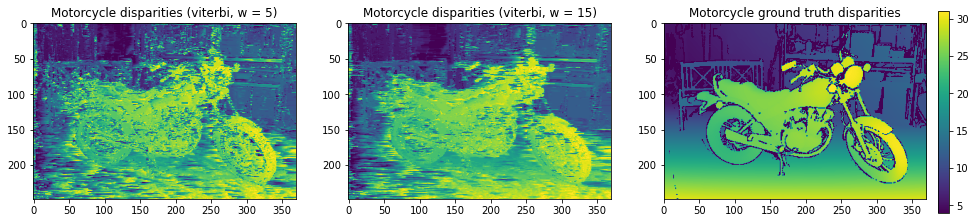

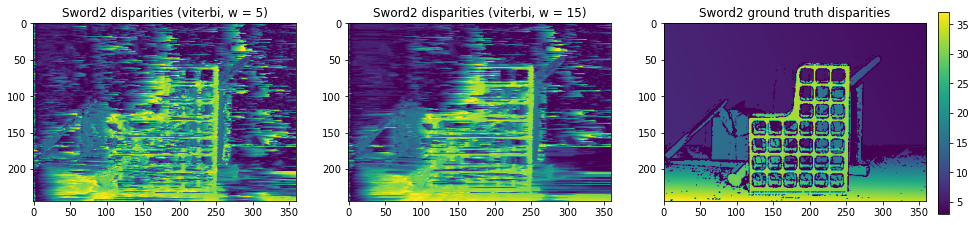

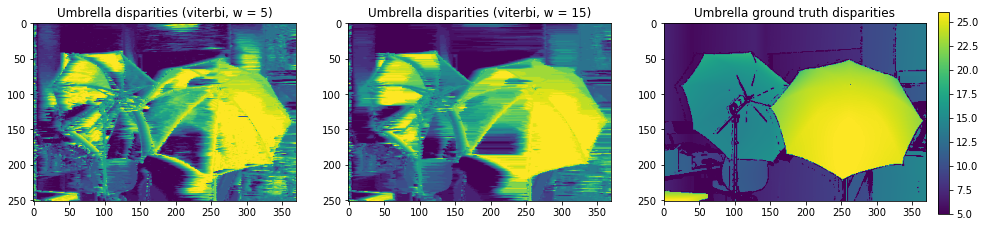

In [6]:
for name, info in images.items():
    images[name]['viterbi_low_w'] = basic_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 5)
    images[name]['viterbi_high_w'] = basic_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15)
    plots = [images[name]['viterbi_low_w'], images[name]['viterbi_high_w'], info['gt']]
    titles = [name + " disparities (viterbi, w = 5)", name + " disparities (viterbi, w = 15)", 
              name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])

#### 2.1.3 Analysis

With a smaller value for $w$ (the regularization factor), more small details of the image could be captured. Using a larger value for $w$ resulted in more accurate results for some parts of the images, but more scan-line artifacts were produced.


### 2.2 Viterbi (with Window costs)
In this algorithm, we combine the Viterbi approach with the window based apporach. This time, the photoconsistency term $D_p(d)$ is computed by averaging the squared differences in some small window of size `window_size`. We use the `windSum` function from the window based apporach for this. That is, for each disparity $d$ we have 
$$D_p(d) = windSum(SD(d), window\_size)$$ 

#### 2.2.1 Implementation

In [7]:
def window_viterbi_dispmap(im_left, im_right, d_min, d_max, w, window_size):
    SD = SD_array(im_left, im_right, d_min, d_max)
    SD_windows = np.array([windSum(s, window_size) for s in SD])
    SD_windows[SD_windows == INFTY] = 0
    disps = np.array(range(d_min, d_max + 1))
    # matrix of regularization weights for disparities:
    disp_curr = np.transpose(np.tile(disps, (len(disps), 1)))
    disp_prev = np.tile(disps, (len(disps), 1))
    reg_weight = w * np.absolute(disp_curr - disp_prev)
    
    return viterbi_image(im_right, disps, SD_windows, reg_weight)

#### 2.2.2 Results

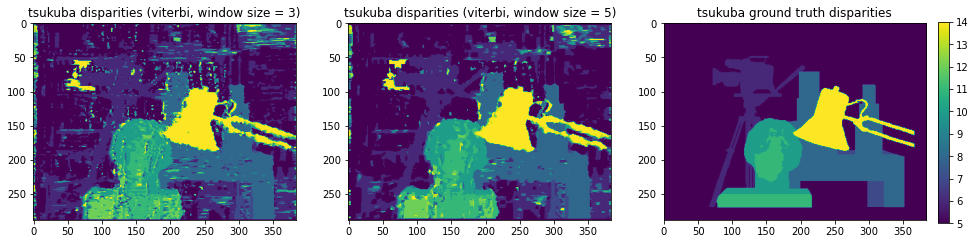

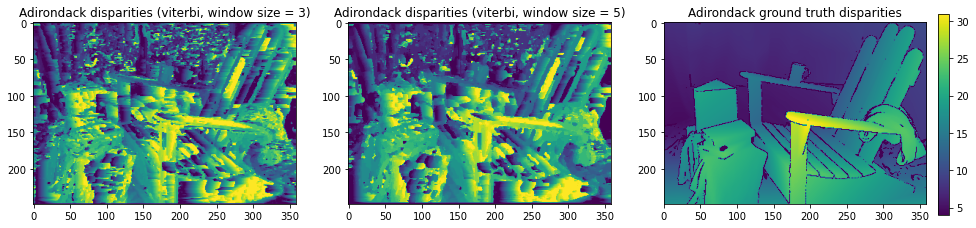

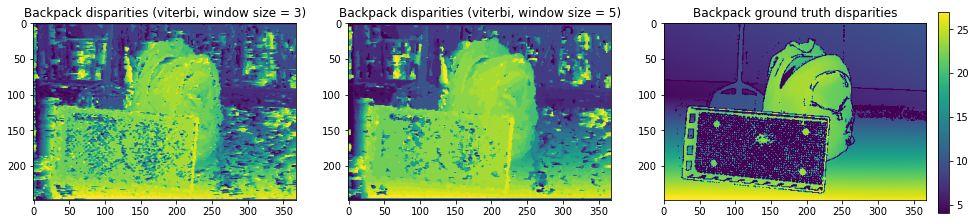

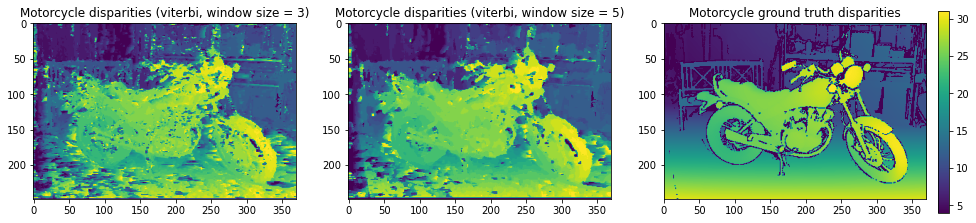

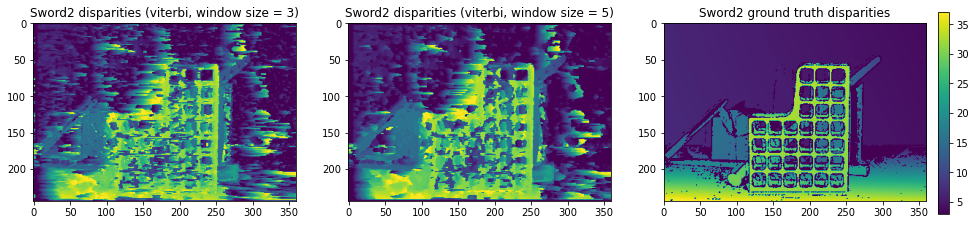

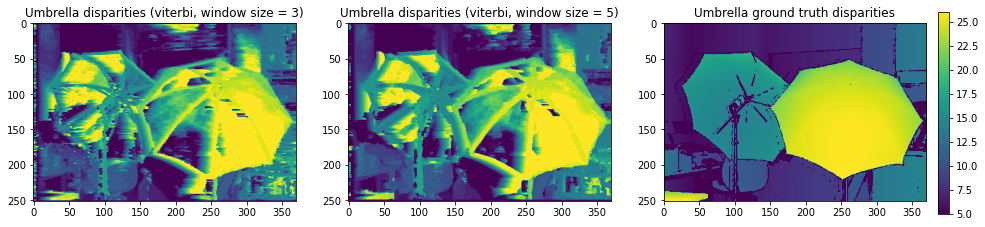

In [8]:
for name, info in images.items():
    images[name]['viterbi_small'] = window_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15, 3)
    images[name]['viterbi_large'] = window_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15, 5)
    plots = [images[name]['viterbi_small'], images[name]['viterbi_large'], info['gt']]
    titles = [name + " disparities (viterbi, window size = 3)", name + " disparities (viterbi, window size = 5)",
              name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])

#### 2.2.3 Analysis

A smaller window for the Viterbi algorithm produced results with more details captured but with more noise. However, when a larger window was used, the results had less noise but more blurred details.


## 3 Full Grid Stereo

### 3.1 Graph Cut (basic)

#### 3.1.1 Implementation

In [9]:
import maxflow

# size is a tuple (length, width), which gives the size of the grid for each layer
# z_weights is an array of size (depth, length, width) (z measures depth)
# x_weights is an array of size (length, width)
# y_weights is an array of size (length, width)
# note depth must be >= 2

# to add edges of "infinite" cost in the opposite direction, we
# use the max cost amongst the weights in z_weights, x_weights, y_weights, 
# multiplied by the number of neighbours (there are 6, but we'll do *100)

def graph_cut_3d(size, z_weights, x_weights, y_weights):
    g = maxflow.GraphInt()
    
    # will use these throughout
    depth, length, width = z_weights.shape
    zeros = np.zeros((length, width))
    inf_cost = 100 * np.amax([np.amax(z_weights), np.amax(x_weights), np.amax(y_weights)])
    
    x_neighbours = [[[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]],
                    [[0, 0, 0],
                     [0, 0, 1],
                     [0, 0, 0]],
                    [[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]]]
    y_neighbours = [[[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]],
                    [[0, 0, 0],
                     [0, 0, 0],
                     [0, 1, 0]],
                    [[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]]]
    z_neighbours_d = [[[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 1, 0],
                       [0, 0, 0]]]
    z_neighbours_u = [[[0, 0, 0], 
                       [0, 1, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]]] # for inf costs 
    nodes = g.add_grid_nodes((depth-1, length, width))
    
    g.add_grid_edges(nodes, x_weights, structure = x_neighbours, symmetric = True)
    g.add_grid_edges(nodes, y_weights, structure = y_neighbours, symmetric = True)
    if depth > 2:
        g.add_grid_edges(nodes, z_weights[1:], structure = z_neighbours_d, symmetric = False)
        g.add_grid_edges(nodes, np.full((depth - 1, length, width), inf_cost), structure = z_neighbours_u, symmetric = False)
    first_layer = nodes[0]
    last_layer = nodes[-1]
    g.add_grid_tedges(first_layer, z_weights[0], zeros)
    g.add_grid_tedges(last_layer, zeros, z_weights[-1])
    
    energy = g.maxflow()
    return 1*g.get_grid_segments(nodes)

def graph_cut_dispmap(im_left, im_right, d_min, d_max, w):
    SD = SD_array(im_left, im_right, d_min, d_max) # z weights
    size = (len(SD) - 1, im_left.shape[0], im_left.shape[1])
    xy_weights = np.full(size, w)
    segmentation = graph_cut_3d(size, SD, xy_weights, xy_weights)
    dispmap = d_min + np.argmax(segmentation, axis = 0)
    dispmap[segmentation[-1] == 0] = d_max
    return dispmap

#### 3.1.2 Results

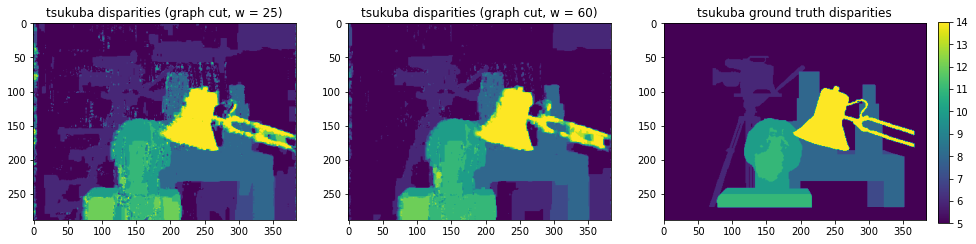

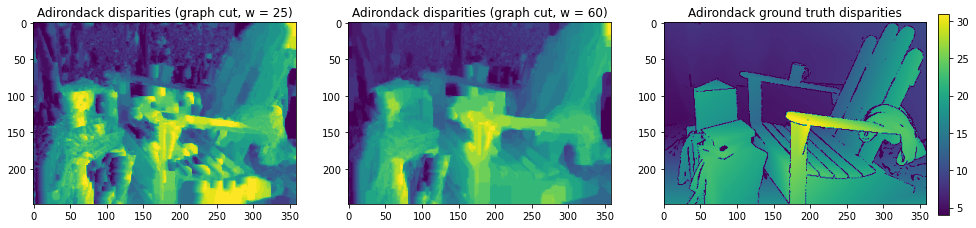

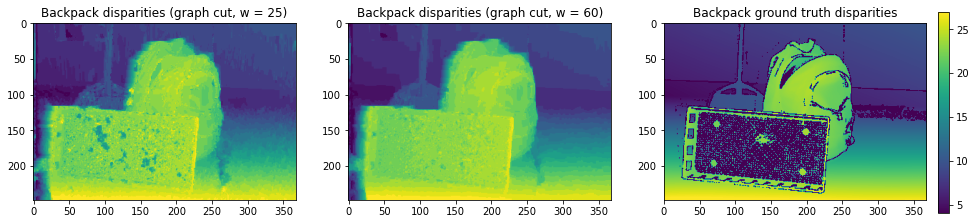

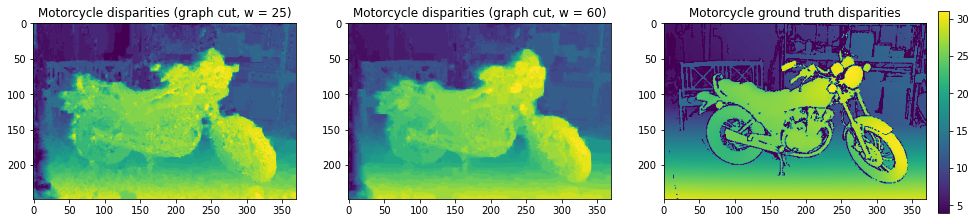

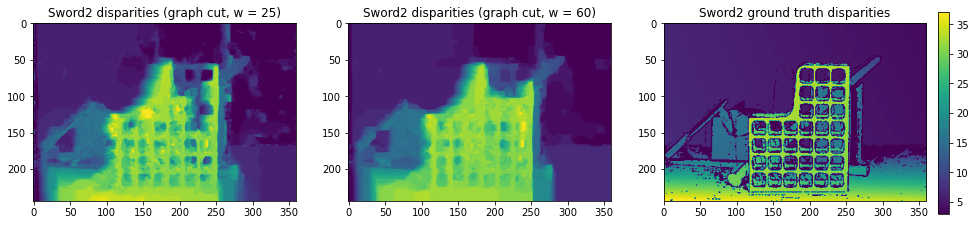

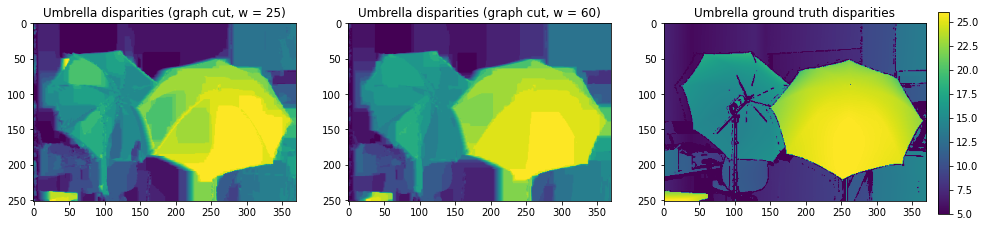

In [10]:
for name, info in images.items():
    images[name]['gc_low_w'] = graph_cut_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 25)
    images[name]['gc_high_w'] = graph_cut_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 60)
    plots = [images[name]['gc_low_w'], images[name]['gc_high_w'], info['gt']]
    titles = [name + " disparities (graph cut, w = 25)", name + " disparities (graph cut, w = 60)", 
              name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])

#### 3.1.3 Analysis
Using a smaller value for $w$ gave resulting disparities with more captured details but also more noise. With a high value for $w$, the results contained less noise and detail.


### 3.2 Graph Cut with Intensity Contrast Spatial Consistency

#### 3.2.1 Implementation

In [11]:
# for regulization weights, use guassian kernel (distance between neighbours)
def smart_graph_cut_dispmap(im_left, im_right, d_min, d_max, w, min_w, sigma):
    SD = SD_array(im_left, im_right, d_min, d_max) # z weights
    size = (len(SD) - 1, im_left.shape[0], im_left.shape[1])
    im = im_left.astype(float)
    x_neighbours = np.roll(im, -1, axis = 1)
    y_neighbours = np.roll(im, -1, axis = 0)
    x_weights = w * np.exp(-np.sum(np.square(im - x_neighbours), axis = -1) / np.square(sigma))
    y_weights = w * np.exp(-np.sum(np.square(im - y_neighbours), axis = -1) / np.square(sigma))
    
    min_weights = np.full(size, min_w)
    
    x_weights = np.maximum(np.array([x_weights] * size[0]), min_weights)
    y_weights = np.maximum(np.array([y_weights] * size[0]), min_weights)
    
    segmentation = graph_cut_3d(size, SD, x_weights, y_weights)
    dispmap = d_min + np.argmax(segmentation, axis = 0)
    dispmap[segmentation[-1] == 0] = d_max
    return dispmap


#### 3.2.2 Results

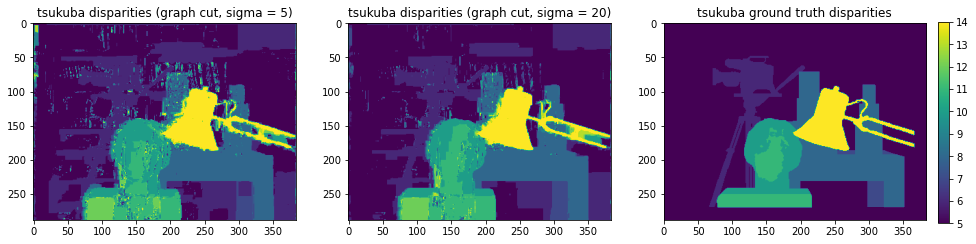

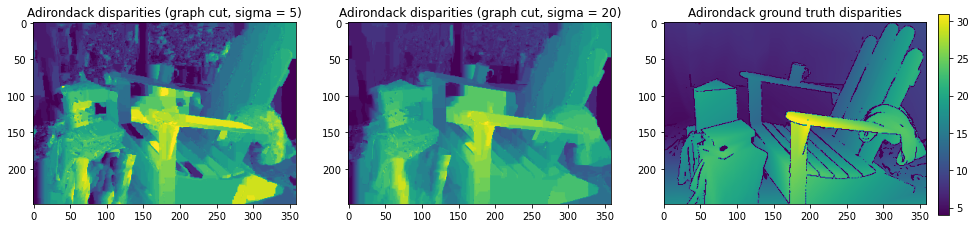

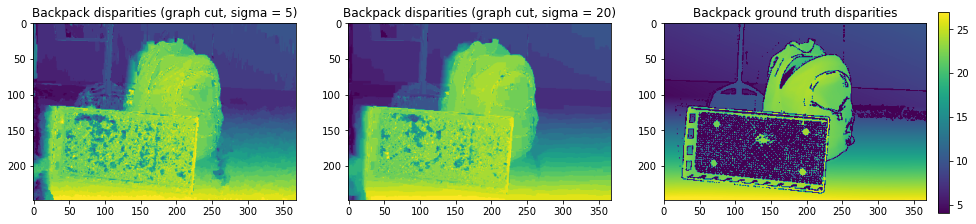

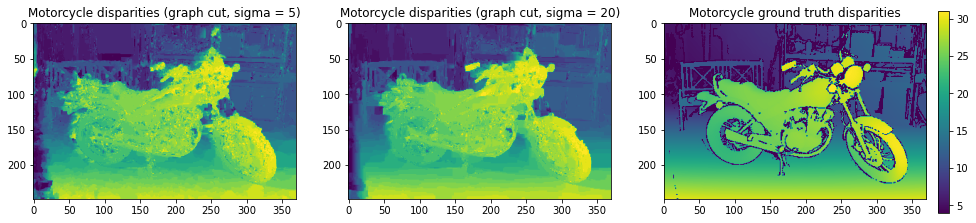

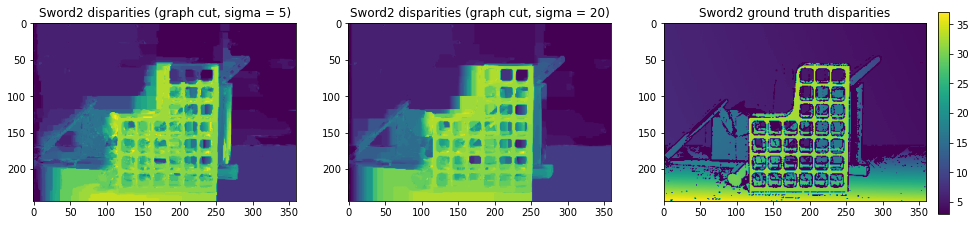

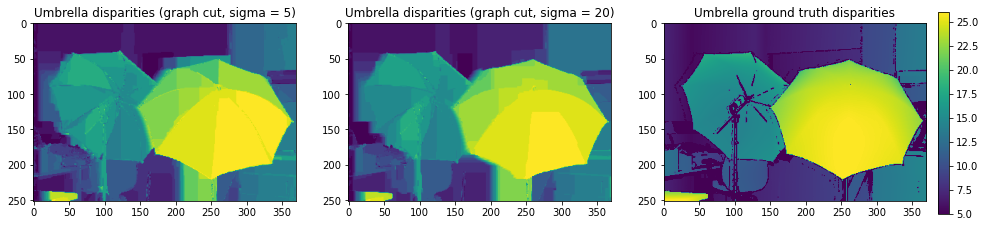

In [12]:
for name, info in images.items():
    images[name]['gc_low_sigma'] = smart_graph_cut_dispmap(info['left'], info['right'], 
                                                           info['d_min'], info['d_max'], 120, 10, 5)
    images[name]['gc_high_sigma'] = smart_graph_cut_dispmap(info['left'], info['right'], 
                                                            info['d_min'], info['d_max'], 120, 10, 20)
    plots = [images[name]['gc_low_sigma'], images[name]['gc_high_sigma'], info['gt']]
    titles = [name + " disparities (graph cut, sigma = 5)", name + " disparities (graph cut, sigma = 20)", name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])

#### 3.2.3 Analysis

When a smaller value for `sigma` was used, the resulting disparities contained more noise and areas of error. With a larger `sigma`, the results were more blurred out but less noise was included.


## 4 Conclusions

To measure the performance of each algorithm, we will calculate the squared difference 

### 4.1 Results

In [14]:
def ssd_per_pixel(disp, gt):
    # ignore pixels with 0 values in either disp or gt
    ignore = ((disp == 0) | (gt == 0))
    sd = np.square(disp - gt)
    valid_sd = np.where(ignore, 0, sd)
    ssd = np.sum(valid_sd)
    num_pixels = np.sum(1*(np.logical_not(ignore)))
    return ssd / num_pixels

for name, info in images.items():
    images[name]['window_small_ssd'] = ssd_per_pixel(info['window_small'], info['gt'])
    images[name]['window_large_ssd'] = ssd_per_pixel(info['window_large'], info['gt'])
    
    images[name]['viterbi_low_w_ssd'] = ssd_per_pixel(info['viterbi_low_w'], info['gt'])
    images[name]['viterbi_high_w_ssd'] = ssd_per_pixel(info['viterbi_high_w'], info['gt'])
    
    images[name]['viterbi_small_ssd'] = ssd_per_pixel(info['viterbi_small'], info['gt'])
    images[name]['viterbi_large_ssd'] = ssd_per_pixel(info['viterbi_large'], info['gt'])
    
    images[name]['gc_low_w_ssd'] = ssd_per_pixel(info['gc_low_w'], info['gt'])
    images[name]['gc_high_w_ssd'] = ssd_per_pixel(info['gc_high_w'], info['gt'])
    
    images[name]['gc_low_sigma_ssd'] = ssd_per_pixel(info['gc_low_sigma'], info['gt'])
    images[name]['gc_high_sigma_ssd'] = ssd_per_pixel(info['gc_high_sigma'], info['gt'])
    
    # print ssd for now
    print(f'| {name} ', end="")
    print(f"| {round(images[name]['window_small_ssd'], 2)} ", end="")
    print(f"| {round(images[name]['window_large_ssd'], 2)} ", end="")

    print(f"| {round(images[name]['viterbi_low_w_ssd'], 2)} ", end="")
    print(f"| {round(images[name]['viterbi_high_w_ssd'], 2)} ", end="")

    print(f"| {round(images[name]['viterbi_small_ssd'], 2)} ", end="")
    print(f"| {round(images[name]['viterbi_large_ssd'], 2)} ", end="")

    print(f"| {round(images[name]['gc_low_w_ssd'], 2)} ", end="")
    print(f"| {round(images[name]['gc_high_w_ssd'], 2)} ", end="")
          
    print(f"| {round(images[name]['gc_low_sigma_ssd'], 2)} ", end="")
    print(f"| {round(images[name]['gc_high_sigma_ssd'], 2)} |")

| tsukuba | 4.06 | 2.39 | 4.85 | 2.8 | 3.25 | 2.78 | 1.44 | 1.33 | 1.76 | 1.32 |
| Adirondack | 65.74 | 40.94 | 76.93 | 66.55 | 66.12 | 60.19 | 36.25 | 23.83 | 31.6 | 21.03 |
| Backpack | 31.85 | 12.86 | 35.48 | 20.13 | 33.02 | 30.08 | 7.81 | 7.58 | 7.51 | 5.23 |
| Motorcycle | 29.01 | 14.71 | 35.35 | 25.0 | 32.12 | 29.34 | 12.01 | 12.04 | 12.05 | 10.29 |
| Sword2 | 91.48 | 78.7 | 97.52 | 77.65 | 91.2 | 93.11 | 55.55 | 57.3 | 53.37 | 48.27 |
| Umbrella | 40.07 | 27.02 | 36.83 | 25.2 | 38.84 | 37.65 | 8.73 | 7.91 | 7.83 | 7.83 |


|Name | Window based (small) | Window based (large) | Scan-line (low w) | Scan-line (high w) | Scan-line (small) | Scan-line (large) | Full grid (low w) | Full grid (high w) | Full grid (low sigma) | Full grid (high sigma) |
|-----|------------------|------------------|-------------------|--------------------|-------------------|-----------|-|-|-|-|
| tsukuba | 4.06 | 2.39 | 4.85 | 2.8 | 3.25 | 2.78 | 1.44 | 1.33 | 1.76 | 1.32 |
| Adirondack | 65.74 | 40.94 | 76.93 | 66.55 | 66.12 | 60.19 | 36.25 | 23.83 | 31.6 | 21.03 |
| Backpack | 31.85 | 12.86 | 35.48 | 20.13 | 33.02 | 30.08 | 7.81 | 7.58 | 7.51 | 5.23 |
| Motorcycle | 29.01 | 14.71 | 35.35 | 25.0 | 32.12 | 29.34 | 12.01 | 12.04 | 12.05 | 10.29 |
| Sword2 | 91.48 | 78.7 | 97.52 | 77.65 | 91.2 | 93.11 | 55.55 | 57.3 | 53.37 | 48.27 |
| Umbrella | 40.07 | 27.02 | 36.83 | 25.2 | 38.84 | 37.65 | 8.73 | 7.91 | 7.83 | 7.83 |

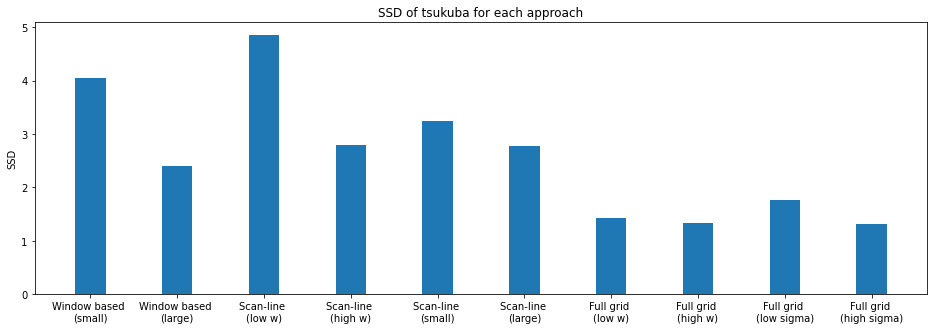

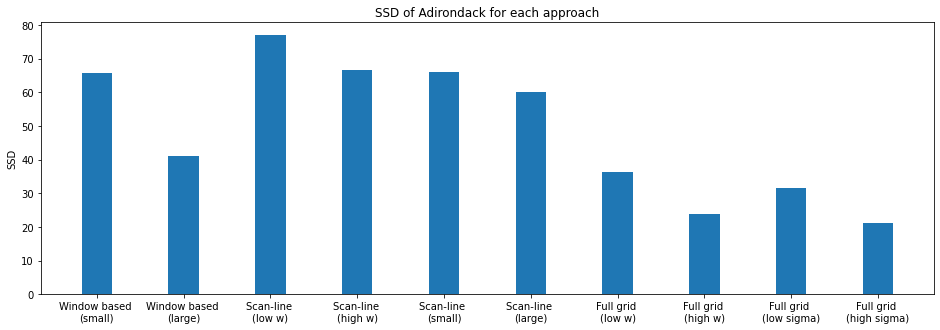

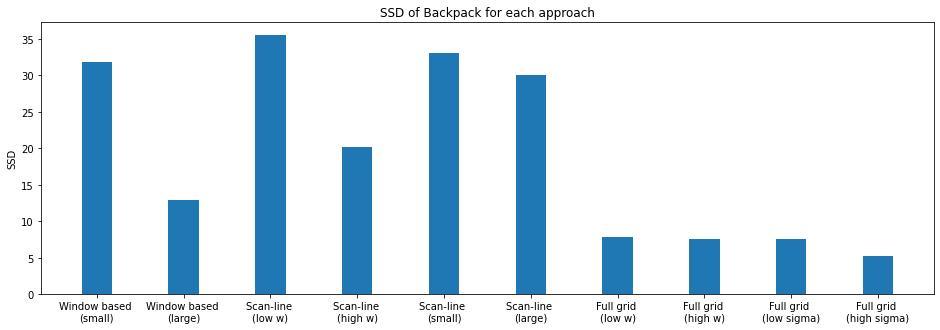

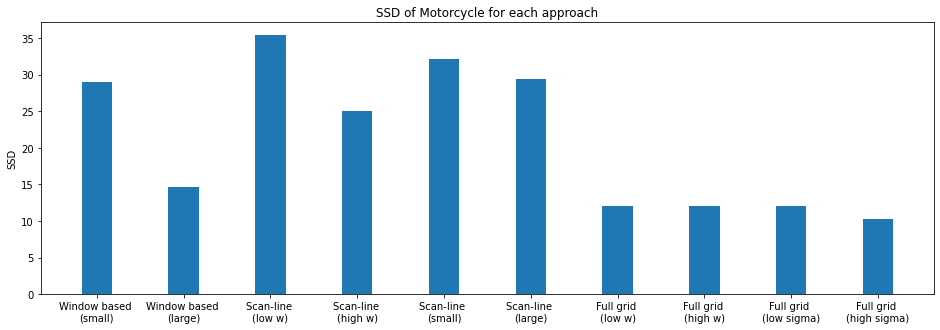

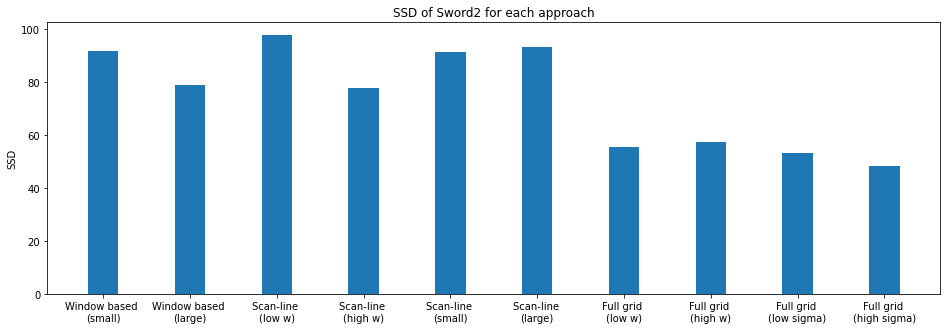

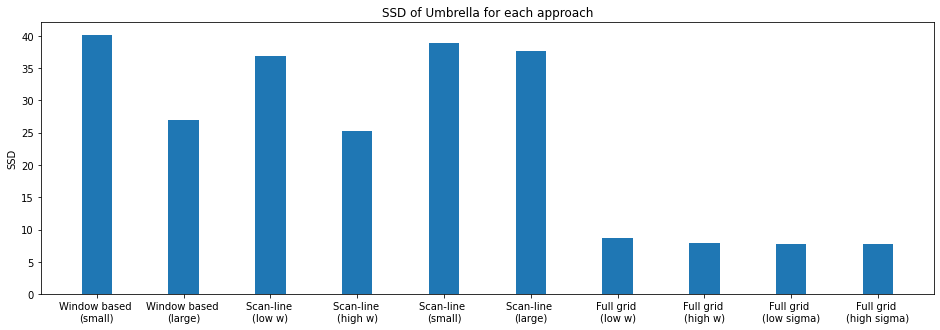

In [15]:
labels = [
    'Window based \n(small)',
    'Window based \n(large)',
    'Scan-line \n(low w)',
    'Scan-line \n(high w)',
    'Scan-line \n(small)',
    'Scan-line \n(large)',
    'Full grid \n(low w)',
    'Full grid \n(high w)',
    'Full grid \n(low sigma)',
    'Full grid \n(high sigma)'
]

categories = [
    'window_small_ssd',
    'window_large_ssd',
    'viterbi_low_w_ssd',
    'viterbi_high_w_ssd',
    'viterbi_small_ssd',
    'viterbi_large_ssd',
    'gc_low_w_ssd',
    'gc_high_w_ssd',
    'gc_low_sigma_ssd',
    'gc_high_sigma_ssd'
]

ind = np.arange(len(categories))    # the x locations for the groups
width = 0.35

for name, data in images.items():
    plt.figure(figsize=(16,5))
    p = plt.bar(ind, [data[c] for c in categories], width)

    plt.ylabel('SSD')
    plt.title('SSD of ' + name + ' for each approach')
    plt.xticks(ind, labels)

    plt.show()

### 4.2 Overall Analysis

We see that the graph based cuts are superior to the other approaches in every case.

### 4.3 Conclusion
two-three paragraphs summarizing the conclusions of your project